# Predicting number of days until a Department of Buildings Complaint is inspected

#### By: Mahdi Shadkam-Farrokhi & Jeremy Ondov

## Boom's Suggestions:

- <input type="checkbox" checked>Cut at 2009</input>
- <input type="checkbox" checked>Proof seasonality</input>
- <input type="checkbox" checked>SARIMAX w/exog</input>
- <input type="checkbox">Daily is preferable</input>
- <input type="checkbox">Do pull outside daily data best</input>
- <input type="checkbox">Cap at 0 when predicting</input>

## Problem Statement
In New York City, building violations are frequently reported to the Department of Buildings(DOB), which is often initiated by a citizen. However, the length of time between the report and a response by the DOB may vary greatly depending on the location, violation type, and other factors.

We'll be using $R^2$ for model selection.

## Executive Summary
...

## Table of Contents
1. 
2. [Resources](#Resources)


## Loading libraries and data
These data were cleaned from the original source. Please see the accompanying notebook for details on the cleaning process.

In [42]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

RANDOM_STATE = 90210

In [11]:
db = pd.read_csv('../datasets/cleaned.csv', index_col = 0, parse_dates = ["date_entered"])

In [12]:
db.head()

,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,med_inc_zip
complaint_number,,,,,,,,,,,
1245555,CLOSED,2009-01-02,930,10025,WEST END AVENUE,NOT SPECIAL,58,BOILR,2009-06-02,151,82352
1245608,CLOSED,2009-01-02,428,10013,BROADWAY,NOT SPECIAL,23,SCFLD,2009-10-09,280,106056
1245621,CLOSED,2009-01-02,146,10001,WEST 28 STREET,NOT SPECIAL,63,ELEVR,2009-01-22,20,85221
1245634,CLOSED,2009-01-03,388,10013,BROADWAY,NOT SPECIAL,56,BOILR,2009-01-07,4,106056
1245648,CLOSED,2009-01-03,375,10016,3 AVENUE,NOT SPECIAL,59,ELCTR,2009-01-08,5,109250


## Data Cleaning

(Please see accompanying notebook)

SUMMARY OF WHAT WAS CLEANED AND WHY
- Filtered "CLOSED"
- Removed nulls
- Removed invalid dates
- Infered `days_until_inspection`
- Removed negative `days_until_inspection`

### Found oddity in zip codes, which no longer exist

Agreed to drop (not included here)

In [13]:
db[db["zip_code"] == 11211].shape

(1026, 11)

In [14]:
db[db["zip_code"] == 11249].shape

(0, 11)

### Must ensure sorted time order

In [50]:
## 

### Expoloring `med_inc_zip`

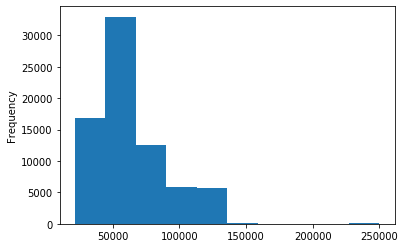

In [87]:
db["med_inc_zip"].plot(kind = "hist")

### Feature engineering log of `med_inc_zip`

In [88]:
db["log_med_inc_zip"] = np.log(db["med_inc_zip"])

### Removing Outliers

(done later - any days_until_insp > 4000)
During model evaluation, we found some significant outliers, which bear consideration.

We've decided to remove these extreme observations from our training set.

In [15]:
db["days_until_inspection"].describe()

count    74340.000000
mean        87.143045
std        209.399509
min          1.000000
25%          5.000000
50%         24.000000
75%         81.000000
max       3767.000000
Name: days_until_inspection, dtype: float64

In [16]:
db.sort_values(by="days_until_inspection", ascending = False).head()

,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,med_inc_zip
complaint_number,,,,,,,,,,,
3305557,CLOSED,2009-05-21,31,11211,DIVISION AVENUE,NOT SPECIAL,31,BKLYN,2019-09-13,3767,66113
4392125,CLOSED,2009-03-06,60-09,11365,172 STREET,NOT SPECIAL,45,QNS.,2019-06-18,3756,63455
3309361,CLOSED,2009-06-22,263,11222,MC GUINNESS BOULEVARD,NOT SPECIAL,49,SPOPS,2019-07-31,3691,78287
4406298,CLOSED,2009-07-01,150-17,11434,LINDEN BOULEVARD,NOT SPECIAL,45,QNS.,2019-07-22,3673,60702
3303034,CLOSED,2009-04-28,385,11238,CLASSON AVENUE,NOT SPECIAL,05,BKLYN,2019-04-30,3654,79013


In [17]:
db["days_until_inspection"].max() / 365 # converting days to years

10.32054794520548

We can see some extreme DOB complaints took over 10 years to be inspected!

It's hard to tell if these are erroneous or valid, since there are many cases like this.

---
During model evaluation, we found the dat associated with 2009-04-02 to have usual observations with large `days_until_inspection`

In [18]:
outlier_dates = ["2009-04-02"]
db[db["date_entered"].isin(outlier_dates)].sort_values("inspection_date", ascending = False).head()

,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,med_inc_zip
complaint_number,,,,,,,,,,,
2128469,CLOSED,2009-04-02,3031,10463,ARLINGTON AVENUE,NOT SPECIAL,1G,EXCAV,2018-05-19,3334,58881
1252772,CLOSED,2009-04-02,315,10017,EAST 46 STREET,NOT SPECIAL,1G,EXCAV,2018-02-16,3242,118469
3300206,CLOSED,2009-04-02,150,11211,NORTH 12 STREET,NOT SPECIAL,1G,STALL,2015-10-21,2393,66113
3300193,CLOSED,2009-04-02,85,11201,FLATBUSH AVENUE EXTENSION,NOT SPECIAL,1G,EXCAV,2013-03-11,1439,116446
3300219,CLOSED,2009-04-02,544,11211,UNION AVENUE,NOT SPECIAL,1G,EXCAV,2012-11-14,1322,66113


There may be some association with these exceptionally long inspection times and the `unit` "EXCAV".

As a threshold, we'll remove all observations above 3200 `days_until_inspection`.

In [19]:
outlier_threshold = 3200
db[db["days_until_inspection"] > outlier_threshold].shape

(23, 11)

We find 24 outlier observations, which account for about .03% of the data.

In [20]:
db = db[db["days_until_inspection"] <= outlier_threshold]

## Exploratory Data Analysis

#### Trying log transformation
Skewed distributions can sometimes be coerced to normal using the log transformation. If this is the case with our target, then we may be able to work with a linear regression or other simple model.

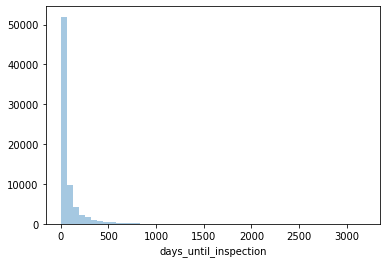

In [21]:
sns.distplot(db["days_until_inspection"], kde = False, bins = 50);

We find a heavily skewed distribution for our target variable, `days_until_inspection`, which is remniscent of an exponential or gamma distribution.

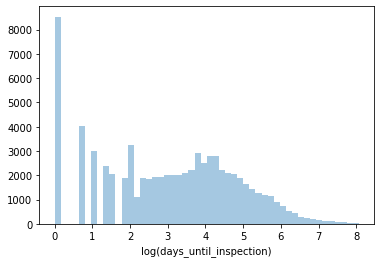

In [22]:
sns.distplot(np.log(db["days_until_inspection"]), axlabel="log(days_until_inspection)", kde = False);

Log transforming our target variable does __not__ result in a normal-looking distribution, so we will keep the target feature as is.

#### Aggregating data by various time intervals

In [23]:
db_with_time_index = db.set_index("date_entered")[["days_until_inspection"]]

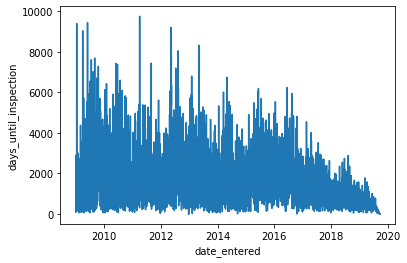

In [24]:
# by day
db_time_by_day = db_with_time_index.resample("D").sum()
sns.lineplot(y = db_time_by_day["days_until_inspection"], x = db_time_by_day.index);

We find after 2016, there appears to be a downward trend in the number of days until a complaint is inspected.

We must consider the recency of the tail end, however, since these complaints are less likely to be "CLOSED" and therefore not seen in the data.

It's difficult to tell if there's any seasonality in these data when aggregating by day.

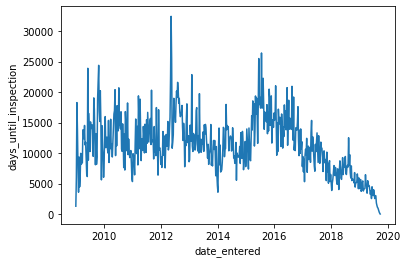

In [90]:
# by week
db_time_by_week = db_with_time_index.resample("W").sum()
sns.lineplot(y = db_time_by_week["days_until_inspection"], x = db_time_by_week.index);

It's difficult to tell if there's any seasonality in these data when aggregating by week.

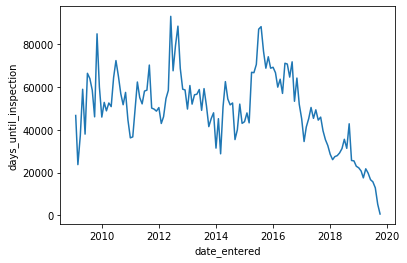

In [91]:
# by month
db_time_by_month = db_with_time_index.resample("M").sum()
sns.lineplot(y = db_time_by_month["days_until_inspection"], x = db_time_by_month.index);

There may be some seasonality by month, though it appears somewhat irregular.

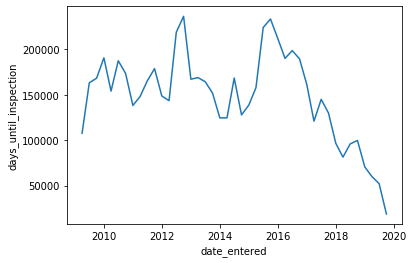

In [92]:
# by quarter
db_time_by_Q = db_with_time_index.resample("Q").sum()
sns.lineplot(y = db_time_by_Q["days_until_inspection"], x = db_time_by_Q.index);

Looking at quarterly aggregations, it's difficult to see a clear regular pattern.

---
We may want to consider testing for seasonality and using an ARIMA or SARIMAX model.

#### Testing for seasonality

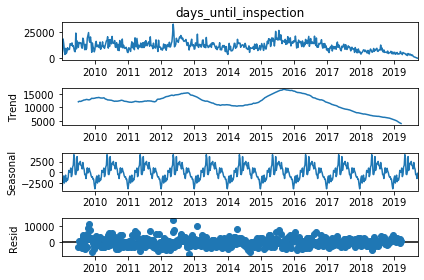

In [28]:
seasonal_decompose(db_time_by_week["days_until_inspection"]).plot()
plt.show()

After decomposing the data we find a seasonal component, which suggests a SARIMAX model may be worth exploring.

### Exploring `Special District`, `Complaint Category` , and `Unit` vs. `days_until_inspection`

In [29]:
def capitalize_words(string):
    '''Returns string with each work capitalized'''
    return " ".join([word.capitalize() for word in string.split()])

In [30]:
def aggregation_plots(db, x, y):
    '''Plots a barplot and boxplot of the given features, limited to top 10 and sorted in descending order'''
    height_per_label = .3
    total_height = len(db[y].unique()[:10]) * height_per_label
    fig, axes = plt.subplots(ncols = 2, figsize = (10, total_height + (2 if total_height< 4 else 0)))
    ax1, ax2 = axes
    
    xlabel = capitalize_words(x.replace("_"," "))
    ylabel = capitalize_words(y.replace("_"," "))
    fig.suptitle("Average {} by {}".format(xlabel,ylabel), y = 1.075)
    
    sorted_label_values = db.groupby(y)[x].agg("mean").sort_values(ascending = False)[:10]

    sns.barplot(ax = ax1, x = db[x], y = db[y], order = sorted_label_values.index)

    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    
    sns.boxplot(ax = ax2, x = db[x], y = db[y], order = sorted_label_values.index)    
    ax2.set_ylabel(ylabel)
    ax2.set_xlabel(xlabel)
    
    plt.tight_layout()

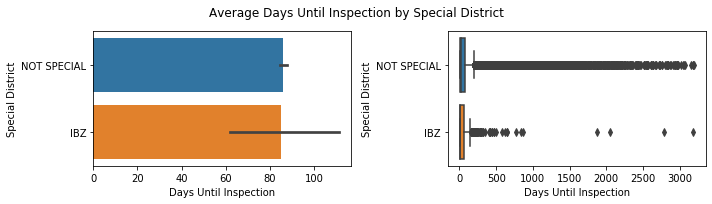

In [31]:
# Special District
aggregation_plots(db, "days_until_inspection", "special_district")

Not seeing much difference in average between Special Districts, however we do see a wide range in individual observations for "NOT SPECIAL" districts.

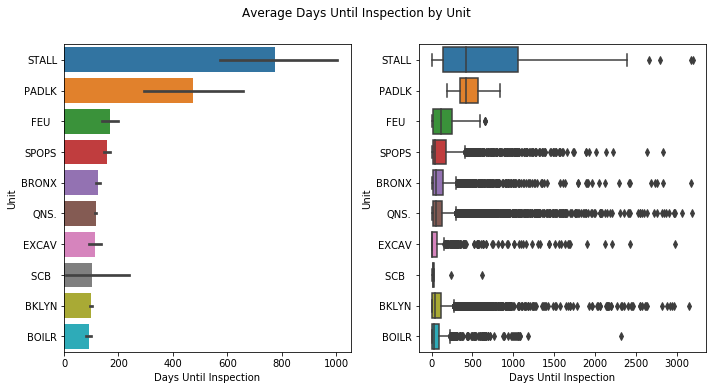

In [32]:
# Unit
aggregation_plots(db, "days_until_inspection", "unit")

The STALL and PADLK units appear to have the longest average days of inspection with little different between the other units. Thos other units, however, have much more extreme ranges.

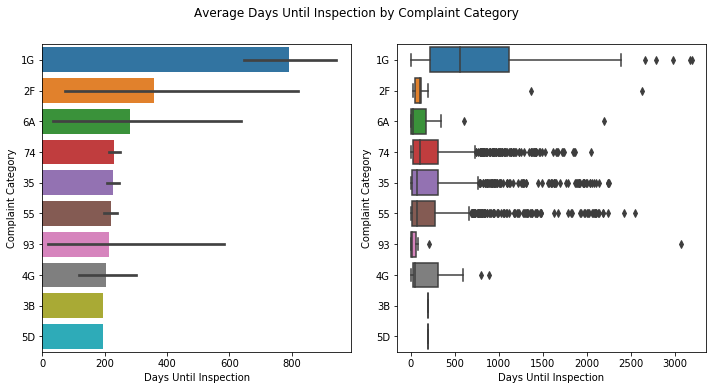

In [33]:
# Complaint Category
aggregation_plots(db, "days_until_inspection", "complaint_category")

The "1G" complaint category appears to take significantly longer to inspect than all other categories, even when taking into account the extreme ranges seen in those categories.

## General Linearized Model (GLM)

### Model Preparation for GLM

Before attempting a SARIMAX model, we'll first explore a general linearized model using the gamma distribution. The target variable, `days_until_inspecti,on`, is bound from $0$ to $\infty$ with an exponentially decreasing frequency.

https://www.statsmodels.org/dev/examples/notebooks/generated/glm.html#GLM:-Gamma-for-proportional-count-response

__Because only using categorical data, this GLM turns into an [ANOVA](https://www.statsmodels.org/dev/anova.html) model__

Therefore, will need to use formula version of GLM because the ANOVA implementation needs to know how categories were formed using the "formula notation" - [source](https://s3.amazonaws.com/assets.datacamp.com/production/course_15356/slides/chapter1.pdf)
- How to use formula notation - [link](https://www.statsmodels.org/dev/examples/notebooks/generated/glm_formula.html)



In [76]:
db.head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection
1,2193181,CLOSED,2013-12-17,573,10458,EAST FORDHAM ROAD,NOT SPECIAL,4B,SEP,2013-12-24,7
6,1265849,CLOSED,2009-09-21,429,10075,EAST 77 STREET,NOT SPECIAL,73,MAN.,2009-10-03,12
12,1404696,CLOSED,2015-09-02,21,10011,WEST 8 STREET,NOT SPECIAL,37,ERT,2015-09-03,1
13,2149422,CLOSED,2010-08-25,2075,10462,WALLACE AVENUE,NOT SPECIAL,23,ERT,2010-10-09,45
14,3312533,CLOSED,2009-07-20,819,11220,59 STREET,NOT SPECIAL,90,CITY,2009-09-15,57


In [77]:
target = "days_until_inspection"
glm_features = ["special_district", "complaint_category", "unit", target]
glm_db = db[glm_features]

#### Creating `vizResids` function

`vizResids` is a convenience function to abstract the relevant regression-like model evaluation graphs:
1. True Values ($y$) vs. Predictions ($\hat{y}$)
2. Residuals Plot
3. Residuals Histogram

In [59]:
def vizResids(model_title, target_name,y_true, y_preds):
    resids = y_true - y_preds
    score = r2_score(y_true, y_preds)
    # HANDLING SUBPLOTS
    fig, axes = plt.subplots(2, 2, figsize=(12,10)) # 2 row x 2 columns
    fig.suptitle(f"{model_title}: $R^2$ ={score:2.2%}", fontsize = 24, y = 1.05)

    ax_1 = axes[0][0]
    ax_2 = axes[0][1]
    ax_3 = axes[1][0]

    subplot_title_size = 18
    subplot_label_size = 14
    
    # 1ST PLOT - y_true vs. y_pred
    ax_1.set_title("True Values ($y$) vs. Predictions ($\hat{y}$)", fontsize = subplot_title_size, pad = 10)
    maxDist = max(max(y_preds),max(y_true)) # maxiumum value used to determin x_lim and y_lim
    minDist = min(min(y_preds),min(y_true)) # maxiumum value used to determin x_lim and y_lim
    # 45deg line, signifying prediction == true value
    ax_1.plot((minDist,maxDist),(minDist,maxDist), c = "r", alpha = .7);
    
    sns.scatterplot(ax = ax_1, x = y_true, y = y_preds, alpha = .25)
    ax_1.set_xlabel("True Values ($y$)", fontsize = subplot_label_size, labelpad = 10)
    ax_1.set_ylabel("Predictions ($\hat{y}$)", fontsize = subplot_label_size, labelpad = 10)

    # 2ND PLOT - residuals
    ax_2.set_title("Residuals", fontsize = subplot_title_size)
    sns.scatterplot(ax = ax_2, x = range(len(resids)),y = resids, alpha = .25)
    ax_2.set_ylabel(target_name, fontsize = subplot_label_size)
    ax_2.axhline(0, c = "r", alpha = .7);

    # 3RD PLOT - residuals histogram
    ax_3.set_title("Histogram of residuals", fontsize = subplot_title_size)
    sns.distplot(resids, ax = ax_3, kde = False);
    ax_3.set_xlabel(target_name, fontsize = subplot_label_size)
    ax_3.set_ylabel("Frequency", fontsize = subplot_label_size)

    plt.tight_layout() # handles most overlaping and spacing issues

### Modeling GLM

In [79]:
glm_gamma = smf.glm(
    formula = "days_until_inspection ~ C(special_district) + C(complaint_category) + C(unit)",
    data = glm_db,
    family = sm.families.Gamma(link = sm.families.links.identity)
).fit()

In [80]:
glm_gamma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                   
=================================================================================
Dep. Variable:     days_until_inspection   No. Observations:                82123
Model:                               GLM   Df Residuals:                    81996
Model Family:                      Gamma   Df Model:                          126
Link Function:                  identity   Scale:                          13.437
Method:                             IRLS   Log-Likelihood:            -4.8830e+05
Date:                   Tue, 11 Feb 2020   Deviance:                   2.0696e+05
Time:                           23:41:13   Pearson chi2:                 1.10e+06
No. Iterations:                      100                                         
Covariance Type:               nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            189.5271     35.704      5.308      0.000     119.549     259.506
C(special_district)[T.NOT SPECIAL]   -19.4644      8.112     -2.400      0.016     -35.363      -3.566
C(complaint_category)[T.03]         -140.6805     34.823     -4.040      0.000    -208.932     -72.429
C(complaint_category)[T.04]         -136.6312     34.833     -3.922      0.000    -204.903     -68.359
C(complaint_category)[T.05]          -74.0716     34.922     -2.121      0.034    -142.517      -5.626
C(complaint_category)[T.06]          -94.3109     38.075     -2.477      0.013    -168.937     -19.685
C(complaint_category)[T.09]         -103.2218     35.606     -2.899      0.004    -173.008     -33.435
C(complaint_category)[T.10]         -136.4546     34.918     -3.908      0.000    -204.893     -68.017
C(complaint_category)[T.12]         -101.6053     38.797     -2.619      0.009    -177.646     -25.565
C(complaint_category)[T.14]          -87.0336     39.756     -2.189      0.029    -164.954      -9.113
C(complaint_category)[T.15]          -99.8707     35.509     -2.813      0.005    -169.467     -30.274
C(complaint_category)[T.16]         -148.4674     35.364     -4.198      0.000    -217.779     -79.156
C(complaint_category)[T.18]         -139.1992     37.860     -3.677      0.000    -213.403     -64.996
C(complaint_category)[T.1A]          -78.7335     40.246     -1.956      0.050    -157.613       0.146
C(complaint_category)[T.1B]         -131.3412     36.294     -3.619      0.000    -202.476     -60.206
C(complaint_category)[T.1C]         -146.2611     35.579     -4.111      0.000    -215.994     -76.529
C(complaint_category)[T.1D]         -112.5486     41.900     -2.686      0.007    -194.672     -30.426
C(complaint_category)[T.1E]         -135.5371     36.969     -3.666      0.000    -207.995     -63.079
C(complaint_category)[T.1G]          791.3972    295.286      2.680      0.007     212.647    1370.148
C(complaint_category)[T.1J]         -145.0328     63.722     -2.276      0.023    -269.926     -20.139
C(complaint_category)[T.1K]           45.8077    196.838      0.233      0.816    -339.988     431.604
C(complaint_category)[T.1L]         -133.8458     35.678     -3.751      0.000    -203.774     -63.918
C(complaint_category)[T.1X]         -146.1966     35.012     -4.176      0.000    -214.818     -77.575
C(complaint_category)[T.1Y]         -178.9647     36.897     -4.850      0.000    -251.282    -106.647
C(complaint_category)[T.1Z]         -137.2443     35.273     -3.891      0.000    -206.379     -68.110
C(complaint_category)[T.20]         -106.2936     34.778     -3.056      0.002    -174.458     -38.130
C(complaint_category)[T.21]          -91.8949     38.077     -2

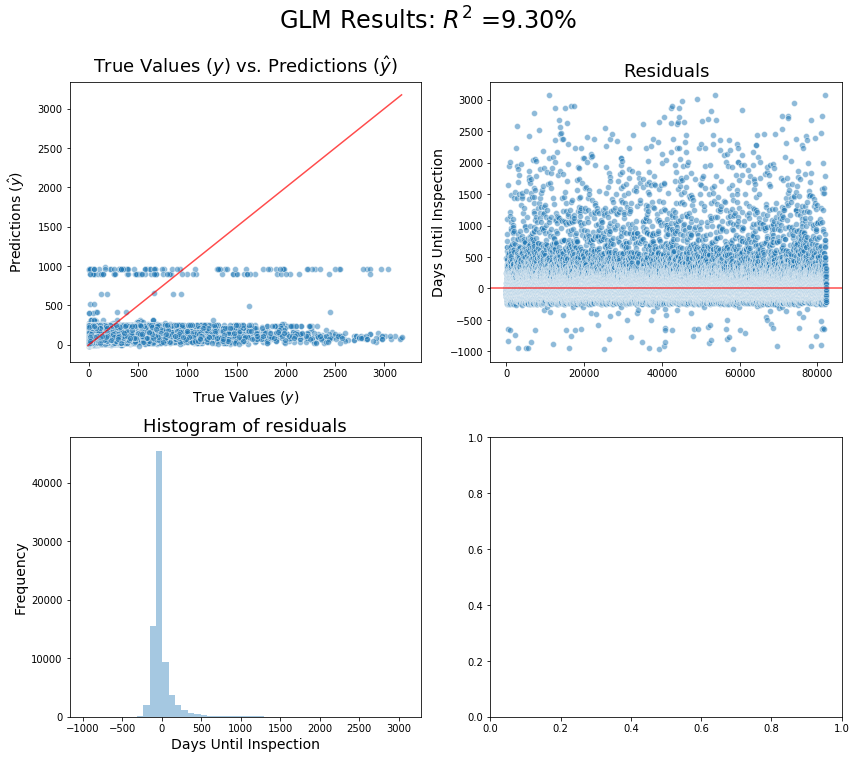

In [81]:
vizResids("GLM Results", "Days Until Inspection", glm_db[target], glm_gamma.predict(glm_db))

The GLM model does a poor job of capturing the variance in the model. Much of the failings of this model is likely due to the fact that all of the features are categorical, turning this linear model into something akin to an ANOVA.

According to the summary, almost all of the categorical dummy features are likely insignificant and may suggest our data severely lacks correlation with our target variable. 

## SARIMAX
We've alread seen some seasonality components in our data, which is a motivating reason for exploring a SARIMAX model.

### Model Preparation for SARIMAX

In [78]:
db.head()

,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,med_inc_zip
complaint_number,,,,,,,,,,,
1245555,CLOSED,2009-01-02,930,10025,WEST END AVENUE,NOT SPECIAL,58,BOILR,2009-06-02,151,82352
1245608,CLOSED,2009-01-02,428,10013,BROADWAY,NOT SPECIAL,23,SCFLD,2009-10-09,280,106056
1245621,CLOSED,2009-01-02,146,10001,WEST 28 STREET,NOT SPECIAL,63,ELEVR,2009-01-22,20,85221
1245634,CLOSED,2009-01-03,388,10013,BROADWAY,NOT SPECIAL,56,BOILR,2009-01-07,4,106056
1245648,CLOSED,2009-01-03,375,10016,3 AVENUE,NOT SPECIAL,59,ELCTR,2009-01-08,5,109250


In [89]:
target = "days_until_inspection"

# ARIMA SETUP
arima_db = db_with_time_index.resample("D").sum().dropna().sort_index()

# EXOGENOUS VARIABLE
sarimax_features = ["special_district","complaint_category","unit","log_med_inc_zip"]
exog = pd.get_dummies(db.set_index("date_entered")[sarimax_features]).resample("D").sum().dropna().sort_index()

#### Determining `d` using ADF (Augmented Dickey Fuller) Test

In [80]:
result = adfuller(arima_db[target])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.778331
p-value: 0.003137
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


With a confidence of 95%, we reject the hypothesis the data has no stationarity, therefore we must conclude the data already has stationarity. 

We will not need to difference (`d = 0`).

#### Determining `p` using autocorrelation function

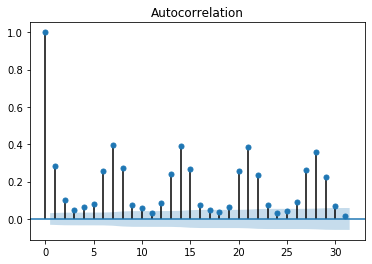

In [93]:
plot_acf(arima_db[target], lags=31)
plt.show()

There is clearly seasonality, therefore difficult to assess the proper value for $p$

#### Determining `q` using partial-autocorrelation function

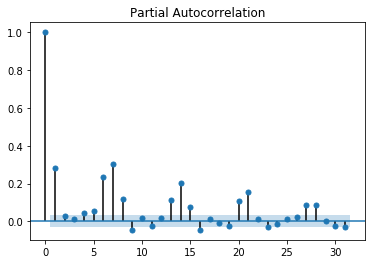

In [94]:
plot_pacf(arima_db[target], lags=31)
plt.show()

Again, there is clearly seasonality, therefore difficult to assess the proper value for $q$

#### Verifying `S`, seasonal component

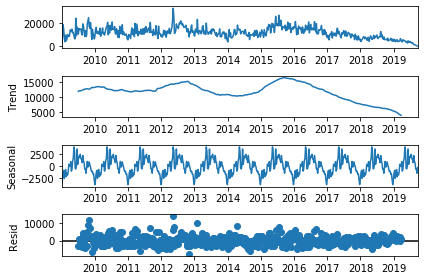

In [95]:
seasonal_decompose(db_time_by_week).plot()
plt.show()

We find a strong weekly seasonal component

### Using `auto_arima` to determine ARIMA and SARIMAX orders


In [81]:
arima_db

,days_until_inspection
date_entered,
2009-01-02,1067
2009-01-03,160
2009-01-04,87
2009-01-05,274
2009-01-06,452
...,...
2019-09-16,5
2019-09-17,15
2019-09-18,10


### Removing outliers
Anything over 4000 days

In [99]:
outlier_mask = arima_db['days_until_inspection'] < 4000
arima_db = arima_db[outlier_mask]
exog = exog[outlier_mask]

In [100]:
arima_db.shape

(3696, 1)

In [101]:
exog.shape

(3696, 147)

In [54]:
fitted_sarimax = auto_arima(
    y         = arima_db,
    exogenous = exog,
    d = 0,
    start_p = 0, max_p = 1,
    start_q = 0, max_q = 1,
    start_P = 0, max_P = 1,
    start_Q = 0, max_Q = 1,
    m = 7, # weekly data
    trace = True,
    error_action = 'ignore',  # don't want to know if an order does not work
    suppress_warnings = True,  # don't want convergence warnings
    random_state = RANDOM_STATE
)

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=64809.704, BIC=65738.007, Fit time=4.528 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=64751.786, BIC=65692.633, Fit time=12.307 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=64758.578, BIC=65699.426, Fit time=38.902 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=64769.619, BIC=65704.194, Fit time=25.831 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 7); AIC=64607.617, BIC=65554.736, Fit time=118.739 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 7); AIC=64541.470, BIC=65482.317, Fit time=116.461 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 7); AIC=64583.748, BIC=65530.868, Fit time=151.043 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 7); AIC=64415.074, BIC=65368.466, Fit time=486.885 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=64448.666, BIC=65395.786, Fit time=426.576 seconds
Fit AR

In [55]:
fitted_sarimax.order

(1, 0, 1)

In [56]:
fitted_sarimax.seasonal_order

(0, 0, 0, 7)

### Modeling SARIMAX

In [102]:
sarima = SARIMAX(endog = arima_db.values,
                 order = fitted_sarimax.order,
                 seasonal_order = fitted_sarimax.seasonal_order,
                 exog = exog.values
#                  trend = "ct"
                )

fitted_sarima = sarima.fit()

In [108]:
fitted_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3696
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -29053.343
Date:                Sun, 01 Mar 2020   AIC                          58406.687
Time:                        21:51:21   BIC                          59338.938
Sample:                             0   HQIC                         58738.476
                               - 3696                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -8.9265      6.769     -1.319      0.187     -22.194       4.341
x2           166.4830    105.070      1.584      0.113     -39.451     372.417
x3           172.6822    101.094      1.708      0.088     -25.458     370.822
x4           195.7129    116.733      1.677      0.094     -33.079     424.505
x5           -20.8292     40.951     -0.509      0.611    -101.093      59.434
x6           -59.1407     37.692     -1.569      0.117    -133.016      14.735
x7            83.7350     33.651      2.488      0.013      17.781     149.689
x8            28.7761     50.727      0.567      0.571     -70.647     128.199
x9            74.1933     39.425      1.882      0.060      -3.079     151.465
x10          -28.4971     43.067     -0.662      0.508    -112.907      55.912
x11           33.8709     59.895      0.566      0.572     -83.521     151.263
x12          279.0484    838.017      0.333      0.739   -1363.435    1921.532
x13           -5.4943     65.867     -0.083      0.934    -134.591     123.602
x14           46.1375     39.286      1.174      0.240     -30.861     123.136
x15          -82.2010    143.516     -0.573      0.567    -363.486     199.085
x16          113.7420    146.941      0.774      0.439    -174.258     401.742
x17           87.8471     49.641      1.770      0.077      -9.448     185.142
x18           71.5976    106.417      0.673      0.501    -136.976     280.171
const       -4.61e-12        nan        nan        nan         nan         nan
x19           73.3281     88.862      0.825      0.409    -100.838     247.494
x20          172.3268     76.869      2.242      0.025      21.666     322.988
x21          -16.6506    145.957     -0.114      0.909    -302.722     269.420
x22          -53.5088    655.089     -0.082      0.935   -1337.459    1230.441
x23            8.2583    197.276      0.042      0.967    -378.396     394.913
x24          -56.0597     57.773     -0.970      0.332    -169.292      57.173
x25         -209.4503    826.812     -0.253      0.800   -1829.973    1411.072
x26          119.9848    810.725      0.148      0.882   -1469.007    1708.977
x27          809.0326   1642.947      0.492      0.622   -2411.085    4029.150
x28            1.1185     46.577      0.024      0.981     -90.171      92.408
x29           56.5984    134.486      0.421      0.674    -206.989     320.186
x30          207.5132     73.442      2.826      0.005      63.569     351.457
x31          227.1130     95.600      2.376      0.018      39.740     414.486
x32           71.7428     49.539      1.448      0.148     -25.352     168.838
x33           94.5703     51.784      1.826      0.068      -6.925     196.066
x34           68.6828     37.105      1.851      0.064      -4.041     141.407
x35           35.8683     68.722      0.522      0.602     -98.825     170.561
x36          -99.0307     79.904     -1.239      0.215    -255.639      57.578
x37          190.0239    178.475      1.065      0.287    -159.781     539.829
x3

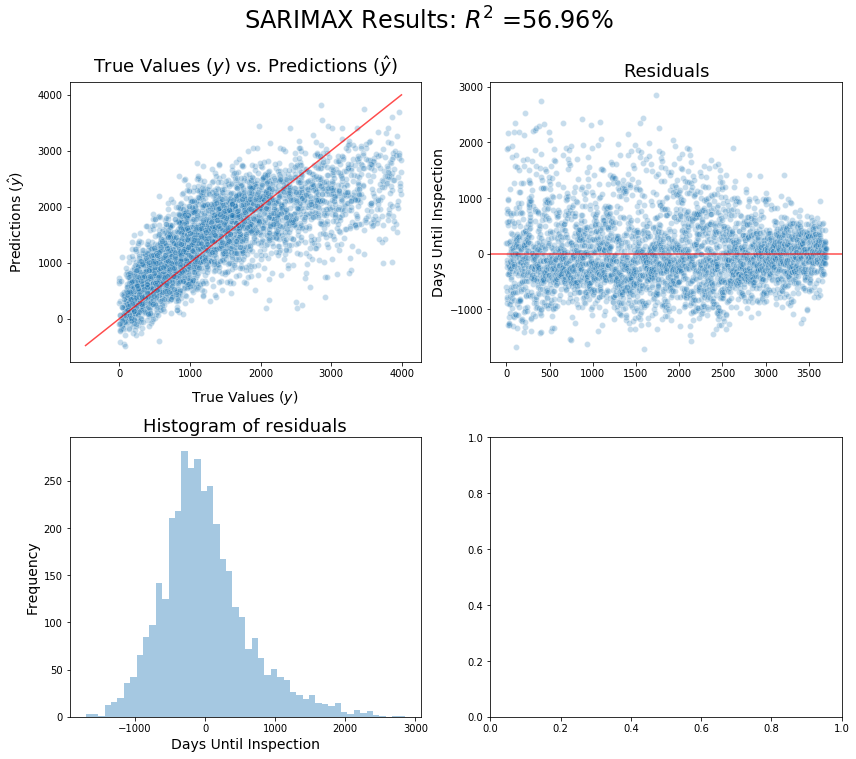

In [103]:
vizResids("SARIMAX Results", "Days Until Inspection", arima_db[target], fitted_sarima.predict(start=0,end=-1))

In [104]:
from sklearn.metrics import mean_squared_error

In [105]:
preds = fitted_sarima.predict(start=0,end=-1)

In [106]:
rmse = mean_squared_error(arima_db[target], preds) ** .5

In [107]:
rmse / 30 / 12

1.742856907246878

Using RMSE, we can see the model is off, on average, by about 1.74 YEARS!

## Classification Model
By converting target into classes, can simplify model and increase performance

### Model Preparation

In [98]:
def bin_days_until_inspection(days):
    if days <= 7:
        return "within 1 week"
    elif days <= 30:
        return "within 30 days"
    elif days <= 30 * 3:
        return "within 1 quarter"
    elif days <= 30 * 6:
        return "within 6 months"
    elif days <= 365:
        return "within 1 year"
    else:
        return "over 1 year"

In [99]:
db["binned_days_until_inspection"] = db["days_until_inspection"].map(bin_days_until_inspection)

In [100]:
db.head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,binned_days_until_inspection
1,2193181,CLOSED,2013-12-17,573,10458,EAST FORDHAM ROAD,NOT SPECIAL,4B,SEP,2013-12-24,7,within 1 week
6,1265849,CLOSED,2009-09-21,429,10075,EAST 77 STREET,NOT SPECIAL,73,MAN.,2009-10-03,12,within 30 days
12,1404696,CLOSED,2015-09-02,21,10011,WEST 8 STREET,NOT SPECIAL,37,ERT,2015-09-03,1,within 1 week
13,2149422,CLOSED,2010-08-25,2075,10462,WALLACE AVENUE,NOT SPECIAL,23,ERT,2010-10-09,45,within 1 quarter
14,3312533,CLOSED,2009-07-20,819,11220,59 STREET,NOT SPECIAL,90,CITY,2009-09-15,57,within 1 quarter


In [101]:
keep_cols = ['zip_code', 'special_district', 'complaint_category',
       'unit']

In [102]:
X = pd.get_dummies(db[keep_cols])
y = db['binned_days_until_inspection']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

### Decision Tree

In [104]:
dt = DecisionTreeClassifier()

In [105]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [106]:
dt.score(X_train, y_train)

0.5291758669957137

In [107]:
dt.score(X_test, y_test)

0.40728654230188494

In [108]:
def pretty_confusion_matrix(y_true, y_pred):
    # handling data
    cm = confusion_matrix(y_true, y_pred)
    labels = y_true.unique()
    labels.sort()
    
    # plotting
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10,4))
    
    sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu",xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

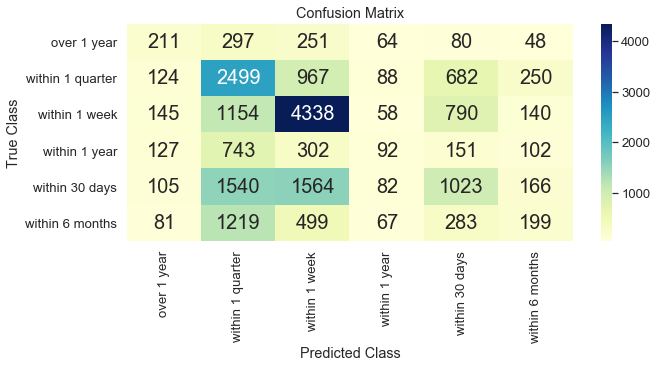

In [110]:
pretty_confusion_matrix(y_test, dt.predict(X_test))

## Adaboost

In [27]:
ada = AdaBoostClassifier()

In [28]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [31]:
ada.score(X_train, y_train)

0.41370410051621703

In [32]:
ada.score(X_test, y_test)

0.41453199571442484

## XGBoostClassifier

In [112]:
xgbc = XGBClassifier()

In [113]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [114]:
xgbc.score(X_train, y_train)

0.4160280555916353

In [115]:
xgbc.score(X_test, y_test)

0.41551799717500365

## XGBoostRegressor

In [40]:
X = pd.get_dummies(db[keep_cols])
y = db['days_until_inspection']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [46]:
xgbr = XGBRegressor(objective="reg:gamma")

In [47]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [48]:
xgbr.score(X_train, y_train)

0.056975260062927406

In [49]:
xgbr.score(X_test, y_test)

0.06124612728820079

## Model Selection

## Model Evaluation

## Conclusion

## Recommendations

## Resources
- [Data Source](https://data.cityofnewyork.us/Housing-Development/DOB-Complaints-Received/eabe-havv)
- [Complaint Codes](https://www1.nyc.gov/assets/buildings/pdf/complaint_category.pdf)
- [Disposition Codes](https://www1.nyc.gov/assets/buildings/pdf/bis_complaint_disposition_codes.pdf)
- [Data Explains](https://docs.google.com/spreadsheets/d/10p0HLqinKbUrSjKaZC2E0ZTHDXgULT0K/edit#gid=1015257717)